### Load packages

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'plotly'

### Import ZLP data

In [276]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat



 ***************************************************** 



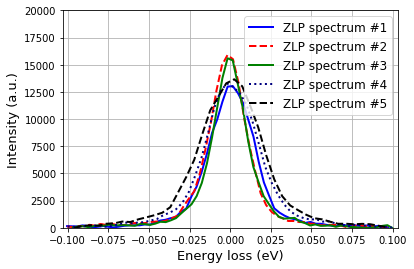

In [277]:
%run EELS-ZLP.py

## Neural Network

### Build architecture

In [278]:
inputsize = len(EELSData_intensity_zlp_2)
outputsize = inputsize

model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(inputsize,1)),
    keras.layers.Dense(inputsize, activation='relu'),
    keras.layers.Dense(outputsize)
])

model.compile(loss='mean_squared_error',
              optimizer='sgd')




## Prepare trainings data 

In [279]:
y_train = EELSData_intensity_zlp_2
x_train = EELSData_Eloss_2
N_train = 10000

vector = np.ones(N_train)
x_train =  np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * x_train), 1, 2)
y_train = np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * y_train), 1, 2)

### Normalization
y_max = np.max(y_train, axis=1)
y_train_norm = np.divide(y_train, y_max[:, None, :])
y_train_norm = np.squeeze(y_train_norm, axis=2)

### Show sample of training data

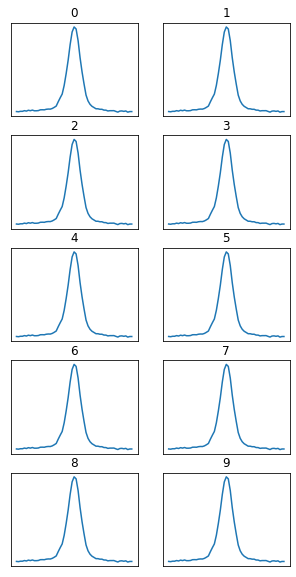

In [280]:
plt.figure(figsize=(5,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(x_train[i], y_train_norm[i])
    plt.title(i)
plt.show()

In [281]:
loss = model.fit(x_train, y_train_norm, batch_size = 5, epochs=10)


Epoch 1/10
10000/10000 [==============================] - 2s 237us/sample - loss: 0.0395
Epoch 2/10
10000/10000 [==============================] - 2s 179us/sample - loss: 0.0032
Epoch 3/10
10000/10000 [==============================] - 2s 181us/sample - loss: 1.9082e-04
Epoch 4/10
10000/10000 [==============================] - 2s 165us/sample - loss: 1.2501e-05
Epoch 5/10
10000/10000 [==============================] - 2s 164us/sample - loss: 8.6489e-07
Epoch 6/10
10000/10000 [==============================] - 2s 166us/sample - loss: 6.1109e-08
Epoch 7/10
10000/10000 [==============================] - 2s 164us/sample - loss: 4.5287e-09
Epoch 8/10
10000/10000 [==============================] - 2s 165us/sample - loss: 5.8125e-10
Epoch 9/10
10000/10000 [==============================] - 2s 176us/sample - loss: 2.0594e-10
Epoch 10/10
10000/10000 [==============================] - 2s 169us/sample - loss: 1.3075e-10


OSError: [Errno 30] Read-only file system: '/trainHistoryDict'

In [310]:
hist_df = pd.DataFrame(loss.history) 
#save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
loss_data = pd.read_csv('history.csv')['loss']

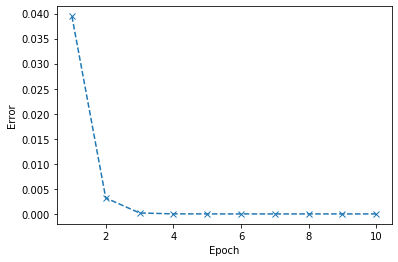

In [311]:
plt.plot(np.linspace(1,10,10), loss_data,'x--')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()